In [2]:
#Install required libraries
get_ipython().system('pip install transformers torch tqdm')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

100%|██████████| 155/155 [01:04<00:00,  2.42it/s]


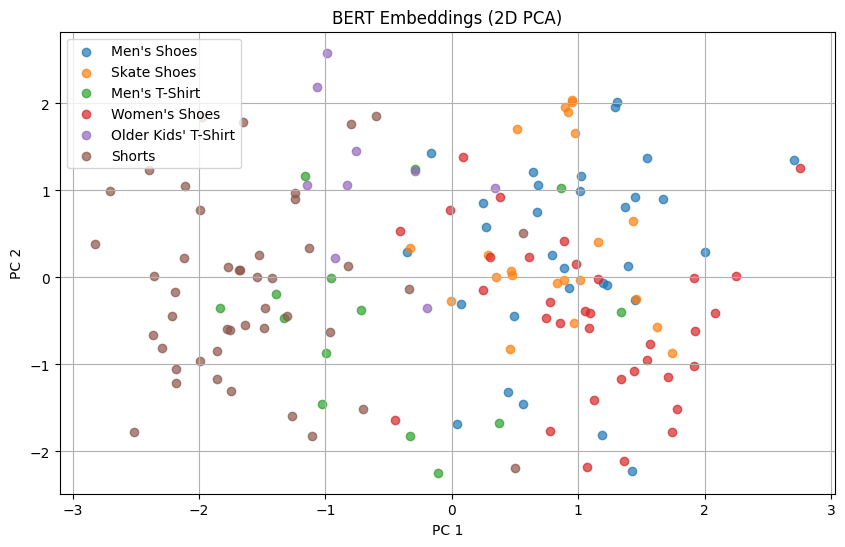

In [4]:
from transformers import BertTokenizer, BertModel
import torch
import pandas as pd
from tqdm import tqdm
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("/content/NikeProductDescriptions (1).csv")
subtitles_to_keep = [
    "Men's Shoes", "Men's T-Shirt", "Women's Shoes",
    "Skate Shoes", "Older Kids' T-Shirt"
]
filtered_df = df[df['Subtitle'].isin(subtitles_to_keep)]
shorts_df = df[df['Subtitle'].str.contains("Shorts", case=False, na=False)].copy()
shorts_df['Subtitle'] = 'Shorts'
final_df = pd.concat([filtered_df, shorts_df], ignore_index=True)

# Load BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Embeddings
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

embeddings = [get_bert_embedding(desc) for desc in tqdm(final_df['Product Description'])]
embedding_df = pd.DataFrame(embeddings)
embedding_df['Subtitle'] = final_df['Subtitle'].values

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embedding_df.drop(columns='Subtitle'))

# Plot
plt.figure(figsize=(10, 6))
for subtitle in embedding_df['Subtitle'].unique():
    indices = embedding_df['Subtitle'] == subtitle
    plt.scatter(pca_result[indices, 0], pca_result[indices, 1], label=subtitle, alpha=0.7)

plt.title('BERT Embeddings (2D PCA)')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend()
plt.grid(True)
plt.show()
